<h1><center>Forest Fire Project<h1/><center/>

<h2><center>Presented by Ophélie Engasser<h2/><center/>

<h3><center>December 2023 - M2 IA Elearning<h3/><center/>

In this project, we will develop a <strong>cellular automaton</strong>, to model the <strong>propagation of a forest fire</strong>. A cellular automaton is a grid of cells (with $n$ rows and $m$ columns), each in a particular state at each time $t$. The state of a cell at time $t + 1$ depends on :<br/>
- The state of neighboring cells on the grid.<br/>
- Its state at the previous time $(t)$ based on transition rules.<br/> 

Here, the transition rules will be the rules of fire propagation, defined as follows :<br/>
1. At the initial state $t$, the forest has a certain <strong>density</strong> : each cell contains either a healthy tree with a probability $p$, or bare ground with a probability $1 - p$.<br/>
2. We randomly set fire on one of the trees.<br/>
3. The fire propagates : an empty cell remains empty, a healthy tree that is a (Van Neumann) neighbor to a burning tree catches fire, a healthy tree with no burning neighbors remains healthy, a burning tree becomes a burned tree, a burned tree remains burned.

We will model this phenomenon using an <strong>object-oriented approach</strong> in Python. Our goal is to refine the model as we progress and derive a purpose : visualize how the fire behaves over time (the number of program iterations) by parameterizing different conditions such as forest density, weather, or firefighters intervention.

Initially, our forest will be a simple matrix, then it will have a <strong>torus-shaped topology</strong>, allowing us to better represent the reality of a forest by avoiding edge effects. Finally, our work will feature a <strong>graphical interface</strong> for a dynamic and visual representation, using the Python tkinter library.</br> 
NB: This work is accompanied by a <strong>UML diagram</strong> depicting the architecture of our model (all classes, their attributes, and methods).</br>
NB2: All attributes are protected within the class (encapsulated), but some are accessible through setter and getter methods. The methods are considered public when they can be called by the user ; otherwise, they are encapsulated.

In [2]:
import random
from copy import deepcopy
import matplotlib.pyplot as plt
import seaborn as sns
import tkinter as tk
from tkinter import Label, Button, Scale

<h1>Tree class<h1/>

In [30]:
class Tree:
    """
    This class gives us details about the state of each grid cell, presenting one tree or one blank.

    An integer rules the state of the tree :
    0 : empty cell
    1 : healthy tree
    2 : burning tree
    3 : burnt tree

    A symbol displays the state of the tree on the console :
    . : state 0
    T : state 1
    F : state 2
    B : state 3
    """
    
    def __init__(self, state=0): # the default state is an empty cell
        self._state = state

    @property
    def state(self):
        return self._state
    
    @state.setter
    def state(self, new_state):
        self._state = new_state
    
    def display_state(self):
        if self._state == 0:
            return '.'
        elif self._state == 1:
            return 'T'
        elif self._state == 2:
            return 'F'
        elif self._state == 3:
            return 'B'
    
    def update_state(self, has_burning_neighbor):
        if has_burning_neighbor and self._state == 1:
            self._state = 2
        elif self._state == 2:
            self._state = 3
      
    def is_burning(self):
        return self._state == 2

In [31]:
#### Test ####

tree0 = Tree()  # create a tree with the default state (empty cell)
tree1 = Tree(1)  # create a healthy tree
tree2 = Tree(2)  # create a burning tree
tree3 = Tree(3)  # create a burnt tree
print(tree0.display_state())  # output: '.'
print(tree1.display_state())  # output: 'T'
print(tree2.display_state())  # output: 'F'
print(tree3.display_state())  # output: 'B'

# Update the state based on the presence of a burning neighbor
tree1.update_state(True)
print(tree1.display_state())  # output: 'F'

# Access to the state attribute that is protected into the class but accessible through a setter
print(tree3.state) # Output: '3'

.
T
F
B
F
3


<h1>Forest class<h1/>

In [32]:
class Forest:
    """
    This class contains all informations about the grid. It is an abstraction of the forest that will catch fire.
    Each cell contains one tree, or a blank, at the initial state of the grid.
    So this class collaborates with class Tree() (relation of composition) in order to behave according to the rules of propagation.
    Only the methods displayed by the user are public, the others are protected.
    """

    def __init__(self, rows, columns, probability=0.6, wind=False, firefighters=False): # p = density of the forest (probability that the cell contain a tree) ; 1-p = density of the blanks
        self._n_rows = rows
        self._n_columns = columns
        self._grid = [[Tree(random.random() < probability) for cols in range(self._n_columns)] for rows in range(self._n_rows)] # composition with the class Tree
        self._probability = probability
        self._wind = wind
        self._firefighters = firefighters
    
    @property
    def rows(self):
        return self._n_rows
    
    @rows.setter
    def rows(self, new_n_rows):
        self._n_rows = new_n_rows
    
    @property
    def columns(self):
        return self._n_columns
    
    @columns.setter
    def columns(self, new_n_columns):
        self._n_columns = new_n_columns
        
    def display_grid(self):
        for row in self._grid:
            for cell in row:
                print(cell.display_state(), end=" ")
            print()

    def manually_set_fire(self, i, j):
        if 0 <= i < self._n_rows and 0 <= j < self._n_columns:
            self._grid[i][j].state = 2

    def randomly_set_fire(self):
        tree_coordinates = [(i, j) for i in range(self._n_rows) for j in range(self._n_columns) if self._grid[i][j]._state == 1]
        if tree_coordinates:
            random_tree_coordinate = random.choice(tree_coordinates)
            i, j = random_tree_coordinate
            self._grid[i][j]._state = 2

    def get_van_neumann_neighbor_coordinates(self, i, j): # 4 neighbors (north, south, east, west)
        return [(i - 1, j), (i + 1, j), (i, j - 1), (i, j + 1)]

    def get_moore_neighbor_coordinates(self, i, j): # 8 neighbors including diagonals
        return [
            (i - 1, j), (i + 1, j), (i, j - 1), (i, j + 1),
            (i - 1, j - 1), (i - 1, j + 1), (i + 1, j - 1), (i + 1, j + 1)
            ]

    def has_burning_neighbor(self, i, j):
        if self._firefighters: # in case of firefighters intervention, there are no more neighbors to consider
            return False
        elif self._wind: # in case of wind, consider 8 neighbors
            neighbors_coordinates = self.get_moore_neighbor_coordinates(i, j)
            for neighbor_i, neighbor_j in neighbors_coordinates:
                if 0 <= neighbor_i < self._n_rows and 0 <= neighbor_j < self._n_columns:
                    if self._grid[neighbor_i][neighbor_j].is_burning():
                        return True
            return False
        else: # in case of normal conditions, consider 4 neighbors
            neighbors_coordinates = self.get_van_neumann_neighbor_coordinates(i, j)
            for neighbor_i, neighbor_j in neighbors_coordinates:
                if 0 <= neighbor_i < self._n_rows and 0 <= neighbor_j < self._n_columns:
                    if self._grid[neighbor_i][neighbor_j].is_burning():
                        return True
            return False

    def update_grid(self):
        new_grid = deepcopy(self._grid)
        for i in range(self._n_rows):
            for j in range(self._n_columns):
                new_grid[i][j].update_state(self.has_burning_neighbor(i, j))
        self._grid = new_grid

    def iterate(self, n_iterations):
        for n in range(abs(n_iterations)):
            self.update_grid()

    def healthy_tree_proportion(self):
        total_cells = self._n_rows * self._n_columns
        tree_cells = sum(1 for row in self._grid for cell in row if cell._state == 1)
        return tree_cells / total_cells

    def _has_burning_trees(self):
        for i in range(self._n_rows):
            for j in range(self._n_columns):
                if self._grid[i][j].is_burning():
                    return True
        return False

    def run_simulation(self):
        iteration = 0
        tree_proportion = self._probability
        self.randomly_set_fire()
        print("The forest is catching fire")
        self.display_grid()
        print(" ")
        while self._has_burning_trees():
            self.update_grid()
            iteration += 1
            print(f"Iteration {iteration}")
            tree_proportion = self.healthy_tree_proportion()
            self.display_grid()
            print(f"Healthy tree proportion : {tree_proportion}")
            print(" ")
        print("The fire is extinguished !")

    def plot_simulation(self):
        iteration = 0
        tree_proportion_list = []
        self.randomly_set_fire()
        while self._has_burning_trees():
            self.update_grid()
            tree_proportion_list.append(self.healthy_tree_proportion())
            iteration += 1
        iterations = range(1, len(tree_proportion_list) + 1)
        plt.figure(figsize=(6, 2))
        sns.lineplot(x=iterations, y=tree_proportion_list, marker='o')
        plt.xlabel("Number of iterations")
        plt.ylabel("Healthy tree proportion")
        plt.title("Fire progression")
        plt.xticks(iterations)
        plt.show()

In [35]:
#### Test ####
forest = Forest(10, 10)

# Display the initial grid
print(f"Initial Grid")
forest.display_grid()

Initial Grid
. T T T . T T T T . 
T T T T . T T T T T 
T . . T T T T . T . 
. . T T . T . T T . 
T T . T . . . T . T 
. T T T . T . . T . 
. . . . T T . T T T 
. . T T T . . T T . 
T T . . T T . T T T 
T T T T T . T . . T 


In [36]:
# Run an entire simulation
forest.run_simulation()

The forest is catching fire
. T T T . F T T T . 
T T T T . T T T T T 
T . . T T T T . T . 
. . T T . T . T T . 
T T . T . . . T . T 
. T T T . T . . T . 
. . . . T T . T T T 
. . T T T . . T T . 
T T . . T T . T T T 
T T T T T . T . . T 
 
Iteration 1
. T T T . B F T T . 
T T T T . F T T T T 
T . . T T T T . T . 
. . T T . T . T T . 
T T . T . . . T . T 
. T T T . T . . T . 
. . . . T T . T T T 
. . T T T . . T T . 
T T . . T T . T T T 
T T T T T . T . . T 
Healthy tree proportion : 0.58
 
Iteration 2
. T T T . B B F T . 
T T T T . B F T T T 
T . . T T F T . T . 
. . T T . T . T T . 
T T . T . . . T . T 
. T T T . T . . T . 
. . . . T T . T T T 
. . T T T . . T T . 
T T . . T T . T T T 
T T T T T . T . . T 
Healthy tree proportion : 0.55
 
Iteration 3
. T T T . B B B F . 
T T T T . B B F T T 
T . . T F B F . T . 
. . T T . F . T T . 
T T . T . . . T . T 
. T T T . T . . T . 
. . . . T T . T T T 
. . T T T . . T T . 
T T . . T T . T T T 
T T T T T . T . . T 
Healthy tree proportion : 0.

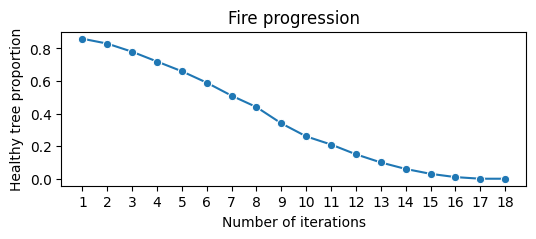

In [20]:
#### Comparison between different conditions : weather, firefighters action ####

# A forest with a density of 90% with normally conditions
forest = Forest(10, 10, probability=0.9) 
forest.plot_simulation()

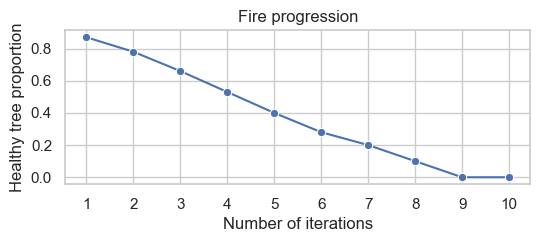

In [73]:
# A forest with a density of 90% with wind
forest = Forest(10, 10, probability=0.9, wind=True) 
forest.plot_simulation()

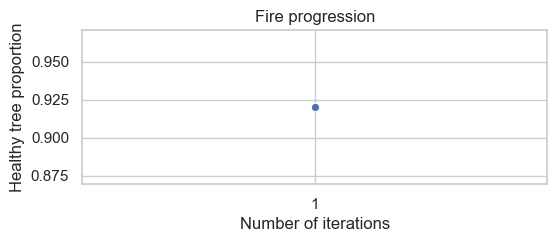

In [75]:
# A forest with a density of 90% with firefighters intervention
forest = Forest(10, 10, probability=0.9, firefighters=True) 
forest.plot_simulation()

The forest burns more rapidly in the presence of wind than under normal conditions. With firefighters intervention, the fire stops immediately.

<h1>Toric forest class<h1/>

In [21]:
class ToricForest(Forest):
    """
    The torus topology involves having the same grid, but with the opposite edges joined together, forming a torus (donut shape). 
    This avoids edge effects : a cell at the border will have a neighbor on the opposite border.
    This class inherits from the Forest class and possesses the same functionalitites. The concept of polymorphism applies to methods 
    get_van_neumann_neighbor_coordinates() and get_moore_neighbor_coordinates() in order to use functionalities of parent class.
    """

    def __init__(self, n_rows, n_columns, probability=0.6, wind=False, firefighters=False):
        super().__init__(n_rows, n_columns, probability, wind, firefighters)
    
    def get_van_neumann_neighbor_coordinates(self, i, j):
        return [
            ((i - 1) % self._n_rows, j),
            ((i + 1) % self._n_rows, j),
            (i, (j - 1) % self._n_columns),
            (i, (j + 1) % self._n_columns)
        ]

    def get_moore_neighbor_coordinates(self, i, j):
        return [
            ((i - 1) % self._n_rows, j),
            ((i + 1) % self._n_rows, j),
            (i, (j - 1) % self._n_columns),
            (i, (j + 1) % self._n_columns),
            ((i - 1) % self._n_rows, (j - 1) % self._n_columns),
            ((i - 1) % self._n_rows, (j + 1) % self._n_columns),
            ((i + 1) % self._n_rows, (j - 1) % self._n_columns),
            ((i + 1) % self._n_rows, (j + 1) % self._n_columns)
        ]

In [22]:
#### Test ####

toric_forest = ToricForest(10, 10)
print(f"Initial Grid")
toric_forest.display_grid()

Initial Grid
T T . . . T T . T . 
T T T . T T . T T T 
. T T T T T T . T T 
T T T T . T T T . T 
T . . T . T T . T T 
T T T T . T T T T . 
. T . T . . . T T . 
T T T . . . . . . . 
T T . T T T T . T T 
. T T T . T . T T . 


In [23]:
# Run entire simulation
toric_forest.run_simulation()

The forest is catching fire
T T . . . T T . T . 
T T T . T T . T T T 
. T T F T T T . T T 
T T T T . T T T . T 
T . . T . T T . T T 
T T T T . T T T T . 
. T . T . . . T T . 
T T T . . . . . . . 
T T . T T T T . T T 
. T T T . T . T T . 
 
Iteration 1
T T . . . T T . T . 
T T T . T T . T T T 
. T F B F T T . T T 
T T T F . T T T . T 
T . . T . T T . T T 
T T T T . T T T T . 
. T . T . . . T T . 
T T T . . . . . . . 
T T . T T T T . T T 
. T T T . T . T T . 
Healthy tree proportion : 0.6
 
Iteration 2
T T . . . T T . T . 
T T F . F T . T T T 
. F B B B F T . T T 
T T F B . T T T . T 
T . . F . T T . T T 
T T T T . T T T T . 
. T . T . . . T T . 
T T T . . . . . . . 
T T . T T T T . T T 
. T T T . T . T T . 
Healthy tree proportion : 0.54
 
Iteration 3
T T . . . T T . T . 
T F B . B F . T T T 
. B B B B B F . T T 
T F B B . F T T . T 
T . . B . T T . T T 
T T T F . T T T T . 
. T . T . . . T T . 
T T T . . . . . . . 
T T . T T T T . T T 
. T T T . T . T T . 
Healthy tree proportion : 0.4

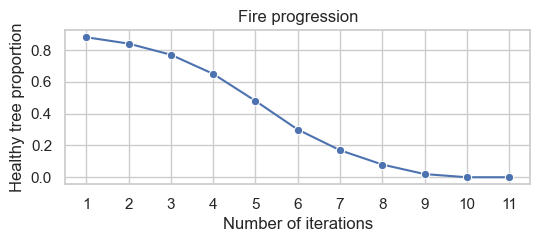

In [103]:
#### Comparison with the burning time of the matrix-based forest ####

toric_forest = ToricForest(10, 10, 0.9)
toric_forest.plot_simulation()

The toric forest under indentical conditions burns more quickly than the matrix-based forest.

Note : Polymorphism works because initializing the 'toric forest' class with a method of the same name as the parent class, which has different functionalities, does not affect the parent class and allows retrieving all the methods without any modification.

<h1>Interface<h1/>

In [37]:
class ForestGUI(Forest):
    """
    This class inherits from the 'forest' class because the interface is based on a grid with delimited borders rather than a torus. 
    A non-toric forest representation is also more user-friendly.
    """

    def __init__(self, n_rows, n_columns, probability=0.6, wind=False, firefighters=False):
        super().__init__(n_rows, n_columns, probability, wind, firefighters)
        self._root = tk.Tk()
        self._root.title("Forest fire simulation")
        self._iterations = 0
        self._labels = []
        self._start_label = Label(self._root, text="Click on a tree to start the simulation")
        self._start_label.grid(row=self._n_rows, columnspan=self._n_columns)
        self._evolution_label = Label(self._root, text=f"Healthy tree proportion : {super().healthy_tree_proportion()}")
        self._evolution_label.grid(row=self._n_rows, columnspan=self._n_columns + 1)
        self._evolution_label.grid_forget()
        self._probability_slider = Scale(self._root, from_=0, to=1, resolution=0.01, orient=tk.HORIZONTAL, label="Set density of the forest",
                                         length=200, sliderlength=10, command=self._update_probability)
        self._probability_slider.set(self._probability)
        self._probability_slider.grid(row=self._n_rows + 1, columnspan=self._n_columns)

    def _update_probability(self, value):
        self._probability = float(value)
        super().__init__(self._n_rows, self._n_columns, self._probability, self._wind, self._firefighters)
        self._update_grid_gui()

    def _click_to_start(self, event, i, j):
        self._probability_slider.destroy()
        row, column = event.widget.grid_info()['row'], event.widget.grid_info()['column']
        if self._grid[i][j]._state == 1:
            super().manually_set_fire(i, j)
            event.widget.config(bg='red')
            for label in self._labels:
                label.unbind("<Button-1>")
            self._iterate_simulation()

    def start_simulation(self):
        for i in range(self._n_rows):
            for j in range(self._n_columns):
                cell_state = self._grid[i][j]._state
                color = 'green' if cell_state == 1 else 'red' if cell_state == 2 else 'grey' if cell_state == 3 else 'white'
                label = Label(self._root, bg=color, width=3, height=1, borderwidth=1, relief="sunken")
                label.grid(row=i, column=j)
                self._labels.append(label)
                label.bind("<Button-1>", lambda event, i=i, j=j : self._click_to_start(event, i, j))
        self._root.mainloop()

    def _update_grid_gui(self):
        for i in range(self._n_rows):
            for j in range(self._n_columns):
                cell_state = self._grid[i][j]._state
                color = 'green' if cell_state == 1 else 'red' if cell_state == 2 else 'grey' if cell_state == 3 else 'white'
                index = i * self._n_columns + j
                self._labels[index].config(bg=color)

    def _iterate_simulation(self):
        self._evolution_label.grid(row=self._n_rows + 1, columnspan=self._n_columns + 1)
        if super()._has_burning_trees():
            old_grid = deepcopy(self._grid)
            super().update_grid()
            new_grid = deepcopy(self._grid)
            if old_grid == new_grid:
                self._start_label.destroy()
                self._evolution_label.destroy()             
            else:
                self._update_grid_gui()
                self._root.after(300, self._iterate_simulation)
                self._iterations += 1
                self._start_label.config(text=f"Iterations : {self._iterations}")
                self._evolution_label.config(text=f"Healthy tree proportion : {super().healthy_tree_proportion()}")

forest_gui = ForestGUI(30, 30)
forest_gui.start_simulation()